In [1]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Activation
from keras.callbacks import LearningRateScheduler, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from EC_Func.metric_plot import plot_confusion_matrix, metric_cal

Using TensorFlow backend.


In [2]:
numClasses = 2
numInputs = 2
data, label = make_blobs(n_samples=10000, centers=numClasses, n_features=numInputs, cluster_std=0.5, random_state=0)

In [3]:
X_train, X_test, y_train_int, y_test_int = train_test_split(data, label, test_size=0.33, random_state=42)
y_train = to_categorical(y_train_int, numClasses)
y_test = to_categorical(y_test_int, numClasses)
mean = np.mean(X_train, axis = 0)
std = np.std(X_train, axis = 0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [4]:
def build_model(input_shape = numInputs):
    model = Sequential()
    model.add(Dense(10, activation = 'relu', kernel_initializer='he_normal', input_shape=(input_shape,)))
    model.add(Dense(8, activation = 'relu', kernel_initializer='he_normal'))
    model.add(Dense(6, activation = 'relu', kernel_initializer='he_normal'))
    model.add(Dense(numClasses, activation = None, kernel_initializer='he_normal'))
    model.add(Activation('softmax'))
    sgd = optimizers.Adam()
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

model = build_model()
print(model.summary())

print('--------------- fit model -----------------')
model.fit(X_train, y_train,
              batch_size=2048,
              epochs=50,
              validation_data=(X_test, y_test),
              shuffle=True, verbose = 0)

pred = model.predict_classes(X_test)
print(confusion_matrix(np.argmax(y_test, axis = 1), pred))
print(accuracy_score(np.argmax(y_test, axis = 1), pred))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 54        
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 14        
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 186
Trainable params: 186
Non-trainable params: 0
_________________________________________________________________
None
--------------- fit model -----------------
[[1629    2]
 [   9 1660]]
0.9966666666666667


In [5]:
from EC_Func.EC_Classifier_Ball_Tree import EpistemicClassifier
layer_interest = [3]
EC = EpistemicClassifier(model, layer_interest, metric = 'minkowski', p = 2) # using mahalanobis for short cut of weight distance
EC.fit(X_train, y_train_int)

Using metric: minkowski
caching hiddens
layer selected: 
dense_4
using Ball Tree for NN Search
building tree for layer 0


In [ ]:
for ep in np.logspace(-4, 0.5, 5):
    pred = EC.predict_class(X_test, dist=[ep])
    plot_confusion_matrix(y_test_int, pred, model.predict_classes(X_test), ep=ep)
    print(ep)

(10000, 2)
(10000,)


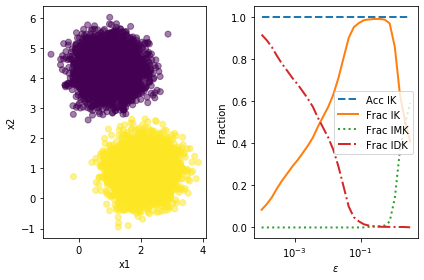

In [6]:
from EC_Func.epsilon_performance_plot import epsilon_performance_curve

import seaborn as sns
fig, ax = plt.subplots(1, 2)

if data.shape[1] == 2: 
    print(data.shape)
    print(label.shape)
    Dataset = pd.DataFrame(np.concatenate((data, label.reshape(-1,1)), axis=1))
    Dataset = Dataset.sort_values(by=2)
    #sns.pairplot(Dataset, kind="scatter", hue = data.shape[1])
    #sns.scatterplot(x=Dataset[0], y=Dataset[1], hue = Dataset[2], alpha=0.5)
    ax[0].scatter(x=Dataset[0], y=Dataset[1], c = Dataset[2], alpha=0.5)
    ax[0].set_xlabel('x1')
    ax[0].set_ylabel('x2')
    
epsilon_performance_curve(EC, model, X_test, y_test_int, epsilon_list = np.logspace(-4, 0.5, 30), plt=ax[1])
fig.tight_layout()

fig.savefig('sigma_05_1')
plt.show()

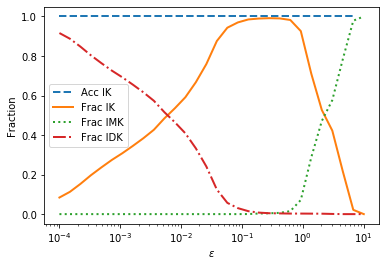

In [7]:
fig, ax = plt.subplots(1, 1)
epsilon_performance_curve(EC, model, X_test, y_test_int, epsilon_list = np.logspace(-4, 1, 30), plt=ax)
fig.savefig('sigma_05_line_1')
plt.show()